In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

import tensorflow as tf

from functools import partial

from collections import defaultdict


import seaborn as sns
import os
import pickle
import numpy as np

import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

class TempSequence :
    def __init__(self) :
        self.temp1 = 1

keras.utils.Sequence = TempSequence

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo


Using TensorFlow backend.


In [2]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)

    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()


In [3]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [4]:
def totalUTR(utrDummy):
    return 'GGGACATCGTAGAGAGTCGTACTTA' + utrDummy

#adding masks of A for start and X for stops to premade datasets as strings to do Johanne's second comparison method 
def maskTomask(utr):
    #modified UTR dissection code ot turn masks into strings execute Johanne's scripts 
    # create masks for if uaug, oof uaug, if stop, oof stop
    fullUTR = totalUTR(utr)
    stops = ['TAA', 'TGA', 'TAG']
    ifuaug_mask = [0] * len(fullUTR)
    oofuaug_mask = [0] * len(fullUTR)
    ifstop_mask = [0] * len(fullUTR)
    oofstop_mask = [0] * len(fullUTR)
    for i in range(0, len(fullUTR) - 2):
        codon = fullUTR[i : i + 3]
        frame = i % 3
        if frame == 0:
            # check start or stop
            if codon == "ATG":
                ifuaug_mask[i] = 1
                ifuaug_mask[i + 1] = 1
                ifuaug_mask[i + 2] = 1
            if codon in stops:
                ifstop_mask[i] = 1
                ifstop_mask[i + 1] = 1
                ifstop_mask[i + 2] = 1
        else:
            if codon == "ATG":
                oofuaug_mask[i] = 1
                oofuaug_mask[i + 1] = 1
                oofuaug_mask[i + 2] = 1
            if codon in stops:
                oofstop_mask[i] = 1
                oofstop_mask[i + 1] = 1
                oofstop_mask[i + 2] = 1
    # trim off the first part which is constant
    #trim and sum? 
    ifstart = ifuaug_mask[25:]
    ifstops = ifstop_mask[25:]
    #print (oofuaug_mask[25:])
    #print (oofstop_mask[25:])
    #turn if stops to masks
    baseString = ["N"] * 50
    for i in range(0, 50):
        if ifstart[i] == 1:
            baseString[i] = "A"
        if ifstops[i] == 1:
            baseString[i] = "X"
    finalString = "".join(baseString)
    return finalString





In [5]:
#Define dataset/experiment name
#dataset_name = "optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc"

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def one_hot_encode_gt(df, col='gt', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'n':[1,0,0,0,0,0,0],'a':[0,1,0,0,0,0,0],'b':[0,0,1,0,0,0,0],'c':[0,0,0,1,0,0,0],'x':[0,0,0,0,1,0,0],'y':[0,0,0,0,0,1,0],'z':[0,0,0,0,0,0,1]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,7])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

#Train data
df_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
x_train = np.expand_dims(one_hot_encode(df_train), axis=1)

#Test data
csv_to_open = "optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512.csv"
dataset_name = csv_to_open.replace(".csv", "")
df_test = pd.read_csv("./" + csv_to_open) #open from scores folder 
#add gt column 
df_test['gt'] = df_test['utr'].apply(lambda x: maskTomask(x))
#loaded test set which is sorted by number of start/stop signals 

#df_test = pd.read_csv("optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc.csv")
x_test = np.expand_dims(one_hot_encode(df_test), axis=1)
y_test = one_hot_encode_gt(df_test)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (15008, 1, 50, 4)
x_test.shape = (512, 1, 50, 4)
y_test.shape = (512, 50, 7)


In [6]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'N' * 50

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [7]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))


In [8]:
#predictor 
#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'

predictor_temp = load_model(predictor_path)

predictor_temp.trainable = False
predictor_temp.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')

#Optimus5 parameters
seq_input_shape = (1, 50, 4)

#Inputs
seq_input = Input(shape=seq_input_shape)

permute_layer = Lambda(lambda x: x[:, 0, ...])

predictor = Model(
    inputs=seq_input,
    outputs=[
        predictor_temp([permute_layer(seq_input)])
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [9]:

def mask_dropout_multi_scale(mask, drop_scales=[1, 2, 4, 7], min_drop_rate=0.0, max_drop_rate=0.5) :
    
    rates = K.random_uniform(shape=(K.shape(mask)[0], 1, 1, 1), minval=min_drop_rate, maxval=max_drop_rate)
    
    scale_logits = K.random_uniform(shape=(K.shape(mask)[0], len(drop_scales), 1, 1, 1), minval=-5., maxval=5.)
    scale_probs = K.softmax(scale_logits, axis=1)
    
    ret_mask = mask
    for drop_scale_ix, drop_scale in enumerate(drop_scales) :
        ret_mask = mask_dropout(ret_mask, rates * scale_probs[:, drop_scale_ix, ...], drop_scale=drop_scale)
    
    return K.switch(K.learning_phase(), ret_mask, mask)

def mask_dropout(mask, drop_rates, drop_scale=1) :
    
    random_tensor_downsampled = K.random_uniform(shape=(
        K.shape(mask)[0],
        1,
        K.cast(K.shape(mask)[2] / drop_scale, dtype=tf.int32),
        K.shape(mask)[3]
    ), minval=0.0, maxval=1.0)
    
    keep_mask_downsampled = random_tensor_downsampled >= drop_rates
    
    keep_mask = K.repeat_elements(keep_mask_downsampled, rep=drop_scale, axis=2)
    
    ret_mask = mask * K.cast(keep_mask, dtype=tf.float32)
    
    return ret_mask

def mask_dropout_single_scale(mask, drop_scale=1, min_drop_rate=0.0, max_drop_rate=0.5) :
    
    rates = K.random_uniform(shape=(K.shape(mask)[0], 1, 1, 1), minval=min_drop_rate, maxval=max_drop_rate)
    
    random_tensor_downsampled = K.random_uniform(shape=(
        K.shape(mask)[0],
        1,
        K.cast(K.shape(mask)[2] / drop_scale, dtype=tf.int32),
        K.shape(mask)[3]
    ), minval=0.0, maxval=1.0)
    
    keep_mask_downsampled = random_tensor_downsampled >= rates
    
    keep_mask = K.repeat_elements(keep_mask_downsampled, rep=drop_scale, axis=2)
    
    ret_mask = mask * K.cast(keep_mask, dtype=tf.float32)
    
    return K.switch(K.learning_phase(), ret_mask, mask)


In [10]:
#open all score and reshape as needed 

file_names = [
    "l2x_" + dataset_name +  "_importance_scores_test.npy",
    "invase_" + dataset_name +  "_conv_importance_scores_test.npy",
    "l2x_" + dataset_name +  "_full_data_importance_scores_test.npy",
    "invase_" + dataset_name +  "_conv_full_data_importance_scores_test.npy",
]
#deepexplain_optimus_utr_OR_logic_synth_1_start_2_stops_method_integrated_gradients_importance_scores_test.npy

model_names =[
    "l2x",
    "invase",
    "l2x_full_data",
    "invase_full_data",
]

model_importance_scores_test = [np.load("./" + file_name) for file_name in file_names]

for scores in model_importance_scores_test:
    print (scores.shape)

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape[-1] > 1 :
        model_importance_scores_test[model_i] = np.sum(model_importance_scores_test[model_i], axis=-1, keepdims=True)

for scores in model_importance_scores_test:
    print (scores.shape)
    
#reshape for mse script -> if not (3008, 1, 50, 1) make it that shape 
idealShape = model_importance_scores_test[0].shape
print (idealShape)

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape != idealShape:
        model_importance_scores_test[model_i] = np.expand_dims(model_importance_scores_test[model_i], 1)
        
for scores in model_importance_scores_test:
    print (scores.shape)


(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)
(512, 1, 50, 1)


In [11]:
#functions of the comparison methods 
def calcNANDReconstructionAccuracy(scores_test, y_test, nts = 6, start_cover_min = 3, stop_cover_min = 3):
    #Calculate NAND reconstruction accuracy
    accs = []
    importance_scores_test = scores_test
    yep = 0
    nope = 0
    for i in range(x_test.shape[0]) :

        plot_i = i
        
        on = np.squeeze(scores_test[i, :])
        #print (on)
        top_ix = np.argsort(on)[::-1][:nts]
        #Start A
        start_cover_a = np.sum(y_test[i, top_ix, 1])

        #Stop X
        stop_cover_x = np.sum(y_test[i, top_ix, 4])

        if (start_cover_a >= start_cover_min) and (stop_cover_x >= stop_cover_min):
            accs.append(1.)
            yep += 1
            
        else :
            accs.append(0.)
            nope += 1
        

    accs = np.array(accs)
    print ("Recovered: ", yep)
    print ("Not Recovered: ", nope)
    print("Logic Function Reconstruction Accuracy = " + str(round(np.mean(accs), 3)))
    return np.mean(accs)


def importanceScoreMetrics(scores_test, y_test, methodName):
    #Calculate operand importance metrics
    scores_test = np.reshape(scores_test, (scores_test.shape[0], 50, 1 ))
    operand_scores = scores_test
    
    bg_scores = []
    start_scores = []
    stop_scores = []

    for i in range(x_test.shape[0]) :
        #Bg
        for j in range(operand_scores.shape[1]) :
            if y_test[i, j, 0] >= 1 :
                bg_scores.append(scores_test[i, j, 0])

        #Start A
        for j in range(operand_scores.shape[1]) :
            if y_test[i, j, 1] >= 1 :
                start_scores.append(scores_test[i, j, 0])
        #Stops X
        for j in range(operand_scores.shape[1]) :
            if y_test[i, j, 4] >= 1 :
                stop_scores.append(scores_test[i, j, 0])
                
    bg_scores = np.array(bg_scores)
    start_scores = np.array(start_scores)
    stop_scores = np.array(stop_scores)

    np.random.shuffle(bg_scores)
    np.random.shuffle(start_scores)
    np.random.shuffle(stop_scores)

    #Plot importance metrics

    mean_bg = np.mean(bg_scores)
    mean_start = np.mean(start_scores)
    mean_stop = np.mean(stop_scores)

    std_bg = np.std(bg_scores)
    std_start = np.std(start_scores)
    std_stop = np.std(stop_scores)

    f = plt.figure(figsize=(6, 4))
    plt.bar([0, 1, 2], [mean_bg, mean_start, mean_stop], edgecolor='black', linewidth=2, color='orange')
    plt.errorbar([0, 1, 2], [mean_bg, mean_start, mean_stop], fmt='o', yerr=[std_bg, std_start, std_stop])
    plt.xticks([0, 1, 2], ["Background", "Start", "Stop"], fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.title(methodName)
    plt.show()


    f = plt.figure(figsize=(6, 4))
    sns.swarmplot(data=[bg_scores[:100], start_scores[:100], stop_scores[:100]])
    plt.xticks([0, 1, 2], ["Background", "Start", "Stop"], fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.title(methodName)
    plt.show()
    
    return mean_bg , mean_start, mean_stop, std_bg, std_start, std_stop
    



METHOD NAME:  l2x
Recovered:  0
Not Recovered:  512
Logic Function Reconstruction Accuracy = 0.0
Recovered:  0
Not Recovered:  512
Logic Function Reconstruction Accuracy = 0.0


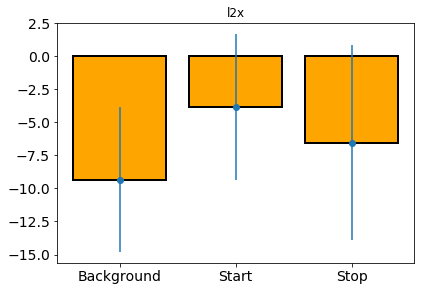

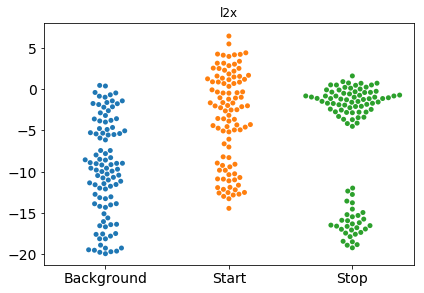

METHOD NAME:  invase
Recovered:  0
Not Recovered:  512
Logic Function Reconstruction Accuracy = 0.0
Recovered:  0
Not Recovered:  512
Logic Function Reconstruction Accuracy = 0.0


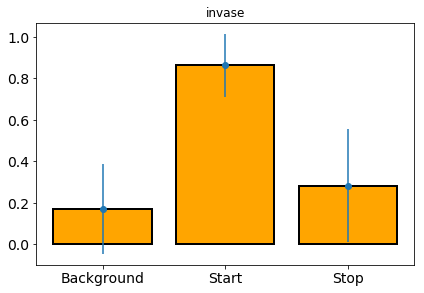

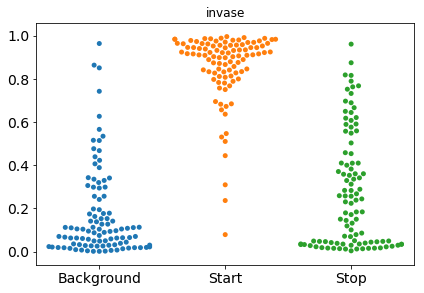

METHOD NAME:  l2x_full_data
Recovered:  0
Not Recovered:  512
Logic Function Reconstruction Accuracy = 0.0
Recovered:  0
Not Recovered:  512
Logic Function Reconstruction Accuracy = 0.0


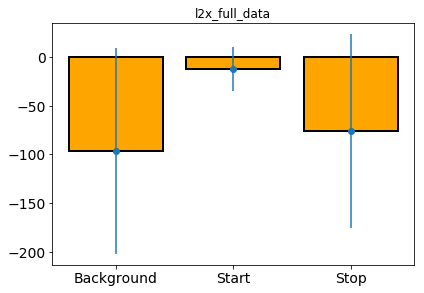

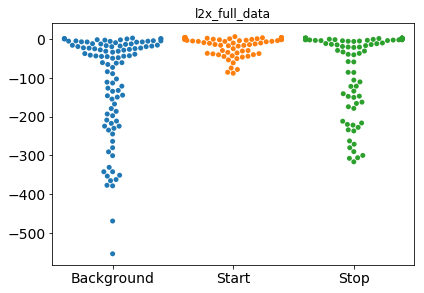

METHOD NAME:  invase_full_data
Recovered:  0
Not Recovered:  512
Logic Function Reconstruction Accuracy = 0.0
Recovered:  0
Not Recovered:  512
Logic Function Reconstruction Accuracy = 0.0


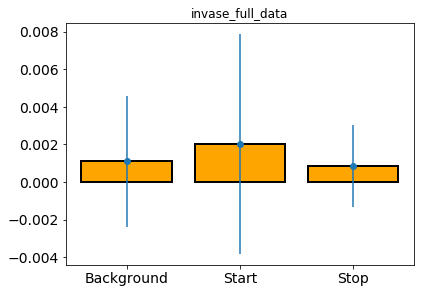

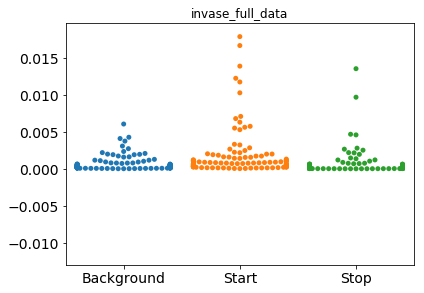

In [12]:
#for each method, plot the values 
encoder = isol.OneHotEncoder(50)

score_clip = None#0.5

output = {'method':[], '6 nts acc':[], '9 nts acc (2 start 1 stop)':[], 'mean_bg':[], 'std_bg':[], 'mean_start':[], 'std_start':[], 'mean_stop':[], 'std_stop':[]}
for i in range(0, len(model_names)):
    
    print ("METHOD NAME: ", model_names[i])

    currentScores =model_importance_scores_test[i]
    #do acc value 
    mean1 = calcNANDReconstructionAccuracy(currentScores, y_test, nts = 6, start_cover_min = 3, stop_cover_min = 3)
    mean2 = calcNANDReconstructionAccuracy(currentScores, y_test, nts = 9, start_cover_min = 6, stop_cover_min = 3)
    #do plots 
    mean_bg , mean_start, mean_stop, std_bg, std_start, std_stop = importanceScoreMetrics(currentScores, y_test,model_names[i] )
    output['method'].append(model_names[i])
    output['6 nts acc'].append(mean1)
    output['9 nts acc (2 start 1 stop)'].append(mean2)
    output['mean_bg'].append(mean_bg)
    output['std_bg'].append(std_bg)
    output['mean_start'].append(mean_start)
    output['std_start'].append(std_start)
    output['mean_stop'].append(mean_stop)
    output['std_stop'].append(std_stop)
    
    
asDF = pd.DataFrame(output)
asDF.to_csv("lowSeq_randomInserts_2_start_1_stop_score_stats_l2x_and_invase_full_data.csv")

In [13]:
asDF

,6 nts acc,9 nts acc (2 start 1 stop),mean_bg,mean_start,mean_stop,method,std_bg,std_start,std_stop
0,0.0,0.0,-9.332037,-3.852898,-6.538843,l2x,5.468493,5.529281,7.343223
1,0.0,0.0,0.170509,0.863038,0.282985,invase,0.216902,0.151729,0.271150
2,0.0,0.0,-96.109688,-11.947408,-75.849403,l2x_full_data,105.919846,22.566902,99.696533
3,0.0,0.0,0.001106,0.002027,0.000860,invase_full_data,0.003474,0.005846,0.002190
